In [4]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
# from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers  import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set some parameters
im_width = 512
im_height = 512


In [6]:
split_ratio = 0.2


from PIL import Image


# Separate val, train path
input_train_dir = '/content/drive/MyDrive/CarDamage/train/Images'
target_train_dir = '/content/drive/MyDrive/CarDamage/train/Masks'
input_val_dir = '/content/drive/MyDrive/CarDamage/val/Images'
target_val_dir = '/content/drive/MyDrive/CarDamage/val/Masks'
input_test_dir = '/content/drive/MyDrive/CarDamage/test'

train_input_img_paths = sorted(
[
    os.path.join(input_train_dir, fname)
    for fname in os.listdir(input_train_dir)

]
)

train_target_img_paths = sorted(
[
    os.path.join(target_train_dir, fname)
    for fname in os.listdir(target_train_dir)

]
)

val_input_img_paths = sorted(
[
    os.path.join(input_val_dir, fname)
    for fname in os.listdir(input_val_dir)

]
)

val_target_img_paths = sorted(
[
    os.path.join(target_val_dir, fname)
    for fname in os.listdir(target_val_dir)

]
)

test_input_img_paths = sorted(
[
    os.path.join(input_test_dir, fname)
    for fname in os.listdir(input_test_dir)

]
)



X_train = np.zeros((len(train_input_img_paths), im_height, im_width, 3), dtype=np.float32)
y_train = np.zeros((len(train_target_img_paths ), im_height, im_width, 1), dtype=np.float32)
X_valid = np.zeros((len(val_input_img_paths ), im_height, im_width, 3), dtype=np.float32)
y_valid = np.zeros((len(val_target_img_paths  ), im_height, im_width, 1), dtype=np.float32)
X_test = np.zeros((len(test_input_img_paths ), im_height, im_width, 3), dtype=np.float32)
mask_train_cord = []
mask_val_cord = []

def preprocessImage(img):
    # Copying input image 
    im = img.copy()
    # Checking if width of input image is greater than its height
    # If condition is true, find the ratio of target width and width of input image width
    # Calculate height by keeping aspect ratio for the target width 
    # Resize image
    if im.size[0] > im.size[1]:
        wpercent = (im_width / float(im.size[0]))
        hsize = int((float(im.size[1]) * float(wpercent)))        
        im = im.resize((im_width, hsize), Image.ANTIALIAS)
    else:
        # If condition is false, find the ratio of target height and height of input image width
        # Calculate width by keeping aspect ratio for the target height 
        # Resize image
        hpercent = (im_height / float(im.size[1]))
        wsize = int((float(im.size[0]) * float(hpercent)))
        im = im.resize((wsize,im_height), Image.ANTIALIAS)    
    new_size = im.size
    preprocessImg = Image.new("RGB", (im_width, im_height))
    # Pasting resized image by keeping aspect ratio to target image
    preprocessImg.paste(im, ((im_width-new_size[0])//2,(im_height-new_size[1])//2))
    return preprocessImg

def preprocessMask(img):
    # Copying input image 
    im = img.copy()  
    # Checking if width of input image is greater than its height
    # If condition is true, find the ratio of target width and width of input image width
    # Calculate height by keeping aspect ratio for the target width 
    # Resize image
    if im.size[0] > im.size[1]:
        wpercent = (im_width / float(im.size[0]))
        hsize = int((float(im.size[1]) * float(wpercent)))        
        im = im.resize((im_width, hsize), Image.ANTIALIAS)
    else:        
        # If condition is false, find the ratio of target height and height of input image width
        # Calculate width by keeping aspect ratio for the target height 
        # Resize image
        hpercent = (im_height / float(im.size[1]))
        wsize = int((float(im.size[0]) * float(hpercent)))
        im = im.resize((wsize,im_height), Image.ANTIALIAS)
    new_size = im.size
    preprocessMsk = Image.new("L", (im_width, im_height))
    # calculate the starting point(x1_cord,y1_cord) to copy resized image to image of target width and height
    x1_cord = ((im_width-new_size[0])//2)
    y1_cord = ((im_height-new_size[1])//2)
    # calculate the ending point(x2_cord,y2_cord) to know the padded pixels
    x2_cord = x1_cord + new_size[0] - 1
    y2_cord = y1_cord + new_size[1] - 1
    # Pasting resized image by keeping aspect ratio to target image
    preprocessMsk.paste(im, (x1_cord,y1_cord))
    return preprocessMsk,(x1_cord,y1_cord,x2_cord,y2_cord)


# Preprocessing training images
for j, path in enumerate(train_input_img_paths ):
    img = load_img(path)
    preprocessImg = preprocessImage(img)
    img = np.asarray(preprocessImg)
    X_train[j] = img/255.0

# Preprocessing training masks    
for j, path in enumerate(train_target_img_paths  ):
    mask = load_img(path)
    preprocessMsk,cord = preprocessMask(mask)
    mask_train_cord.append(cord)
    mask = np.asarray(preprocessMsk)
    mask = np.expand_dims(mask,axis=-1)
    y_train[j] = mask/1.0
    
# Preprocessing validation images     
for j, path in enumerate(val_input_img_paths ):
    img = load_img(path)
    preprocessImg = preprocessImage(img)
    img = np.asarray(preprocessImg)    
    X_valid[j] = img/255.0

# Preprocessing validation masks     
for j, path in enumerate(val_target_img_paths  ):
    mask = load_img(path)
    preprocessMsk,cord = preprocessMask(mask)
    mask_val_cord.append(cord)
    mask = np.asarray(preprocessMsk)
    mask = np.expand_dims(mask,axis=-1)
    y_valid[j] = mask/1.0

# Preprocessing test images     
for j, path in enumerate(test_input_img_paths ):
    img = load_img(path)
    preprocessImg = preprocessImage(img)
    img = np.asarray(preprocessImg)    
    X_test[j] = img/255.0  

Below code can be used to visualize the images and corresponding masks

Text(0.5, 1.0, 'defect')

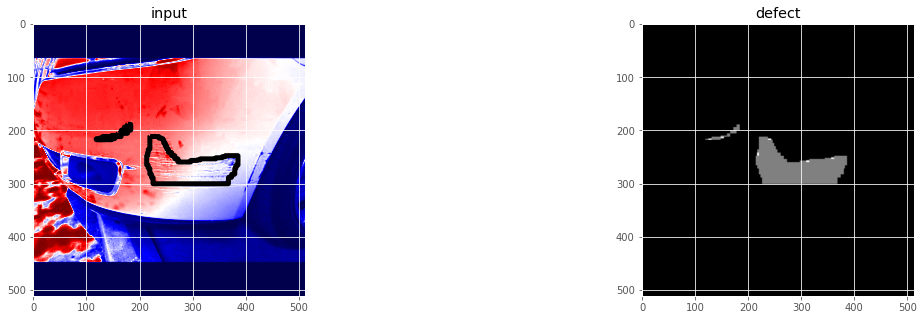

In [7]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('input')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('defect')

In [8]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [9]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
from keras import backend as K
from keras.losses import binary_crossentropy

# def bce_dice_loss(y_true, y_pred):    
#     return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# def dice_coef(y_true, y_pred, smooth=1):
#     intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#     union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
#     return (2. * intersection + smooth) / ( union + smooth)

# def dice_coef_loss(y_true, y_pred):
#     return 1-dice_coef(y_true, y_pred)

# def dice_coef(y_true, y_pred, smooth=1):
#   intersection = K.sum(y_true * y_pred, axis=[1,2,3])
#   union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
#   dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
#   return dice

# def dice_coef_loss(y_true, y_pred):
#     return 1-dice_coef(y_true, y_pred)

In [11]:
from numpy.random import seed
seed(42)
# from tensorflow import set_random_seed
# set_random_seed(42)

input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=[dice_coef])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 512, 512, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [13]:
callbacks = [
    # EarlyStopping(patience=30, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/CarDamage/output/model2.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [14]:
results = model.fit(X_train, y_train, batch_size=2, epochs=100, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.8604 - dice_coef: 0.1381
Epoch 1: val_loss improved from inf to 0.90639, saving model to /content/drive/MyDrive/CarDamage/output/model2.h5
25/25 [==============================] - 110s 4s/step - loss: 0.8604 - dice_coef: 0.1381 - val_loss: 0.9064 - val_dice_coef: 0.0909 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.8326 - dice_coef: 0.1657
Epoch 2: val_loss improved from 0.90639 to 0.89983, saving model to /content/drive/MyDrive/CarDamage/output/model2.h5
25/25 [==============================] - 106s 4s/step - loss: 0.8326 - dice_coef: 0.1657 - val_loss: 0.8998 - val_dice_coef: 0.0980 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.8176 - dice_coef: 0.1805
Epoch 3: val_loss improved from 0.89983 to 0.86465, saving model to /content/drive/MyDrive/CarDamage/output/model2.h5
25/25 [==============================] - 105s 4s/step - loss: 0.8176 - d

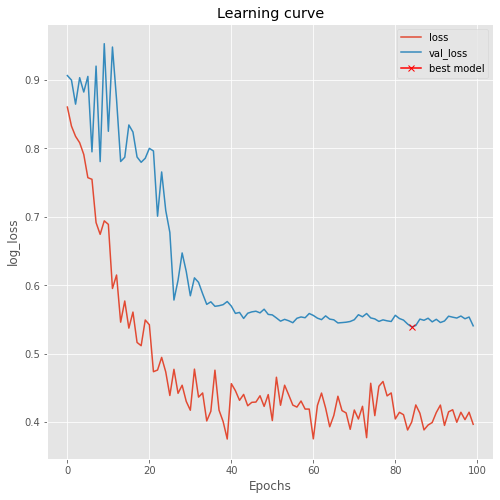

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [17]:
# load the best model
model.load_weights('/content/drive/MyDrive/CarDamage/output/model2.h5')

In [18]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 7s 7s/step - loss: 0.4222 - dice_coef: 0.5778


[0.4222271740436554, 0.577772855758667]

In [21]:

preds_train = model.predict(X_valid, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_test = model.predict(X_test, verbose=1)

1/1 [==============================] - 2s 2s/step


In [ ]:
#segmentation for labelled data


In [30]:
input_labelled_data_dir = '/content/drive/MyDrive/CarDamage/Labelled data'

In [31]:
labelled_input_img_paths = sorted(
[
    os.path.join(input_labelled_data_dir, fname)
    for fname in os.listdir(input_labelled_data_dir)

]
)


In [32]:
labelled = np.zeros((len(labelled_input_img_paths), im_height, im_width, 3), dtype=np.float32)

In [33]:
def preprocessImage(img):
    # Copying input image 
    im = img.copy()
    # Checking if width of input image is greater than its height
    # If condition is true, find the ratio of target width and width of input image width
    # Calculate height by keeping aspect ratio for the target width 
    # Resize image
    if im.size[0] > im.size[1]:
        wpercent = (im_width / float(im.size[0]))
        hsize = int((float(im.size[1]) * float(wpercent)))        
        im = im.resize((im_width, hsize), Image.ANTIALIAS)
    else:
        # If condition is false, find the ratio of target height and height of input image width
        # Calculate width by keeping aspect ratio for the target height 
        # Resize image
        hpercent = (im_height / float(im.size[1]))
        wsize = int((float(im.size[0]) * float(hpercent)))
        im = im.resize((wsize,im_height), Image.ANTIALIAS)    
    new_size = im.size
    preprocessImg = Image.new("RGB", (im_width, im_height))
    # Pasting resized image by keeping aspect ratio to target image
    preprocessImg.paste(im, ((im_width-new_size[0])//2,(im_height-new_size[1])//2))
    return preprocessImg


In [34]:
# Preprocessing training images
for j, path in enumerate(labelled_input_img_paths):
    img = load_img(path)
    preprocessImg = preprocessImage(img)
    img = np.asarray(preprocessImg)
    labelled[j] = img/255.0


In [35]:
preds_labelled = model.predict(labelled, verbose=1)

2/2 [==============================] - 23s 7s/step


In [37]:
preds_labelled

array([[[[0.00804281],
         [0.0066601 ],
         [0.00640222],
         ...,
         [0.00493991],
         [0.00501207],
         [0.00741982]],

        [[0.00705031],
         [0.00392449],
         [0.00355062],
         ...,
         [0.00270402],
         [0.00244817],
         [0.00561938]],

        [[0.00565737],
         [0.00263077],
         [0.00228652],
         ...,
         [0.00202364],
         [0.00173932],
         [0.00420544]],

        ...,

        [[0.00636569],
         [0.0028193 ],
         [0.00279725],
         ...,
         [0.00209463],
         [0.00175059],
         [0.00335249]],

        [[0.00595215],
         [0.00262246],
         [0.00221011],
         ...,
         [0.00172523],
         [0.00152019],
         [0.00354093]],

        [[0.00783119],
         [0.00798437],
         [0.00584114],
         ...,
         [0.0050306 ],
         [0.00459313],
         [0.00682878]]],


       [[[0.00804281],
         [0.0066601 ],
         [0.00

In [36]:
plot_sample(preds_labelled )

NameError: ignored

In [ ]:
# Threshold predictions
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
import cv2
def write_mask_image(dest_image_path,dest_mask_path,index,data = 'test'):
    if data == 'train':
#         print('hi')
        cords = list(mask_train_cord[i])
        x1 = cords[0]
        y1 = cords[1] 
        x2 = cords[2] + 1
        y2 = cords[3] + 1
        crop_img = np.copy(X_train[index])
        crop_img = crop_img[y1:y2, x1:x2] * 255.0
        crop_img = crop_img.astype(np.uint8)
        crop_mask = np.copy(preds_val_t[index])
        crop_mask = crop_mask[y1:y2, x1:x2] * 255
        crop_img = cv2.cvtColor(crop_img,cv2.COLOR_RGB2BGR)
        file_name = os.path.basename(train_input_img_paths[index])
        cv2.imwrite(os.path.join(dest_image_path,file_name),crop_img)
        cv2.imwrite(os.path.join(dest_mask_path,file_name),crop_mask)
    elif data == 'val':
        
        cords = list(mask_val_cord[i])
        x1 = cords[0]
        y1 = cords[1] 
        x2 = cords[2] + 1
        y2 = cords[3] + 1
        # print(x1,y1,x2,y2)
        crop_img = np.copy(X_valid[index])
        crop_img = crop_img[y1:y2, x1:x2] * 255.0
        crop_img = crop_img.astype(np.uint8)
        crop_mask = np.copy(preds_val_t[index])
        crop_mask = crop_mask[y1:y2, x1:x2] * 255
        crop_img = cv2.cvtColor(crop_img,cv2.COLOR_RGB2BGR)
        file_name = os.path.basename(val_input_img_paths[index])
#         print(file_name)
        cv2.imwrite(os.path.join(dest_image_path,file_name),crop_img)
        cv2.imwrite(os.path.join(dest_mask_path,file_name),crop_mask)
    

img_path = '/content/drive/MyDrive/CarDamage/Result/Image'
mask_path = '/content/drive/MyDrive/CarDamage/Result/Pred_mask'
for i in range(0,len(preds_val_t)):    
    write_mask_image(img_path,mask_path,i,"val")
#train test
# for i in range(0,len(preds_train_t)):    
#     write_mask_image(img_path,mask_path,i,True)

In [ ]:
superimposed_image_folder = "/content/drive/MyDrive/CarDamage/Result/Super"
mask_files = os.listdir(mask_path)

for eachmaskFile in mask_files:
#     print(eachmaskFile)
    img = cv2.imread(os.path.join(img_path,eachmaskFile))
    mask_img = cv2.imread(os.path.join(mask_path,eachmaskFile),0)
    h,w,c = img.shape  
    mask_rgb = np.zeros((h,w,3),dtype=np.uint8)
    mask_img = np.uint8(127 * mask_img)
    # mask_rgb[:,:,0] = mask_img
    mask_rgb[:,:,1] = mask_img
    # mask_rgb[:,:,2] = mask_img
    alpha = 0.3
    superimposed_img = mask_rgb * (alpha) + img *(1-alpha)
    cv2.imwrite(os.path.join(superimposed_image_folder,eachmaskFile),superimposed_img)

In [ ]:
import cv2

def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ixs = len(preds)
#         ix = random.randint(0, len(X))
            
    for ix in range(0,ixs):      
        has_mask = y[ix].max() > 0

        fig, ax = plt.subplots(1, 4, figsize=(20, 10))
        ax[0].imshow(X[ix, ..., 0], cmap='seismic')
        if has_mask:
             ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
        ax[0].set_title('Seismic')

        ax[1].imshow(y[ix].squeeze())
        ax[1].set_title('Mask')

        ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
        if has_mask:
            ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
        ax[2].set_title( 'Predicted')

        ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
        # if has_mask:
        #     ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
        # ax[3].set_title('Predicted binary');

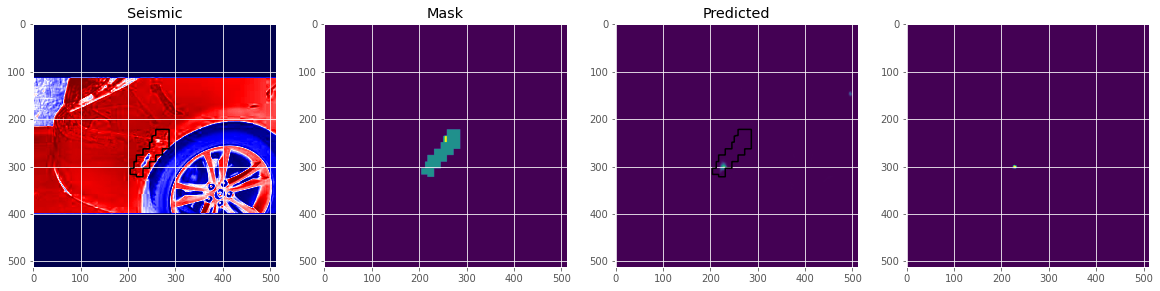

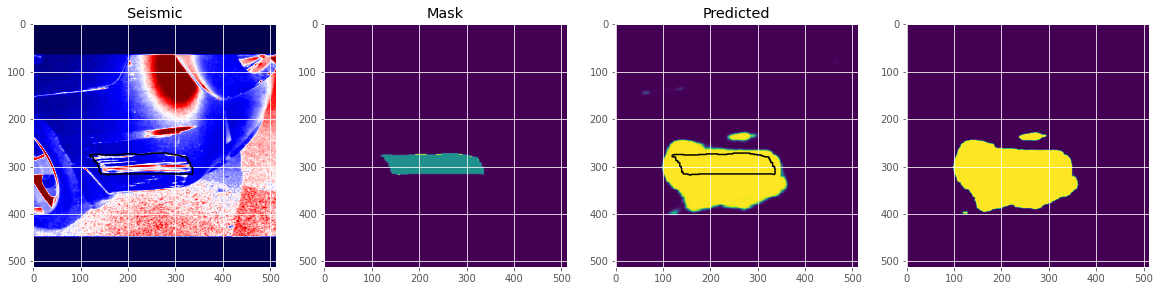

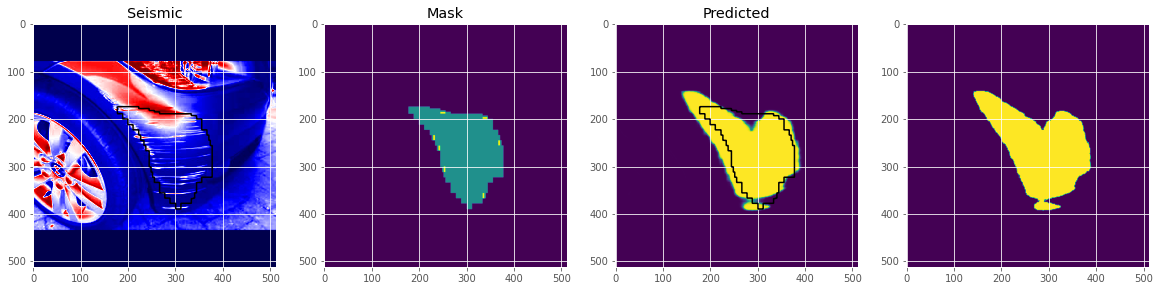

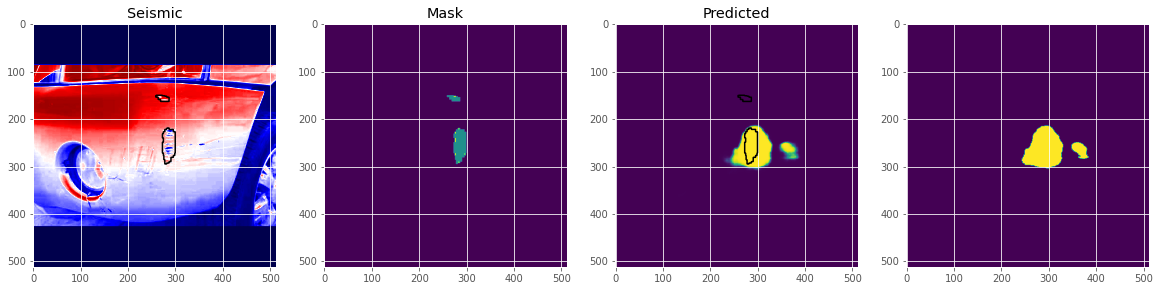

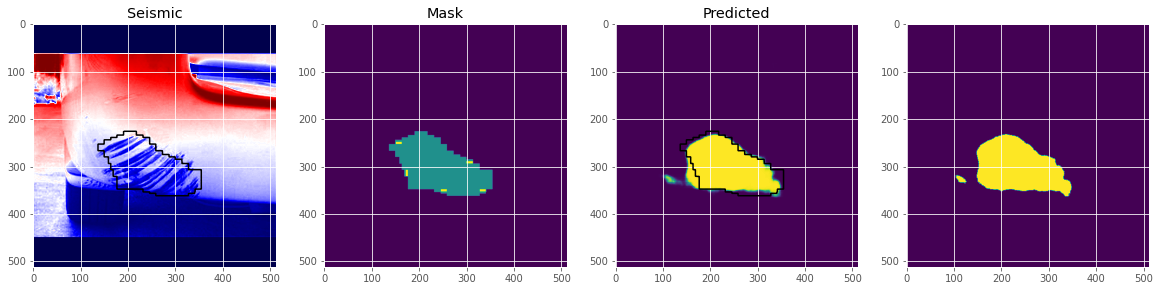

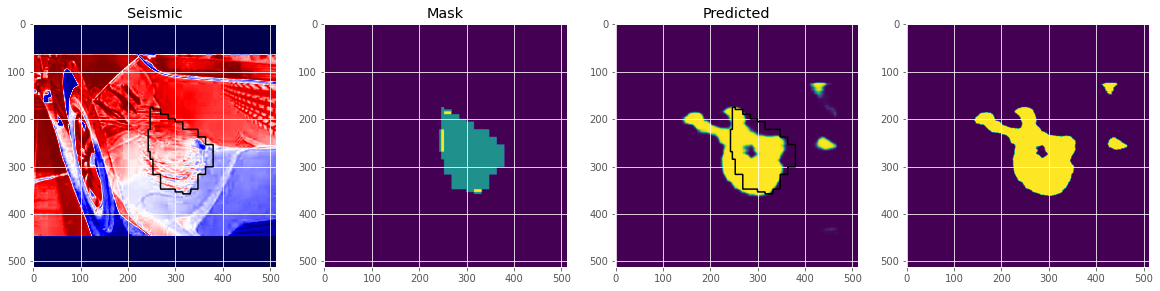

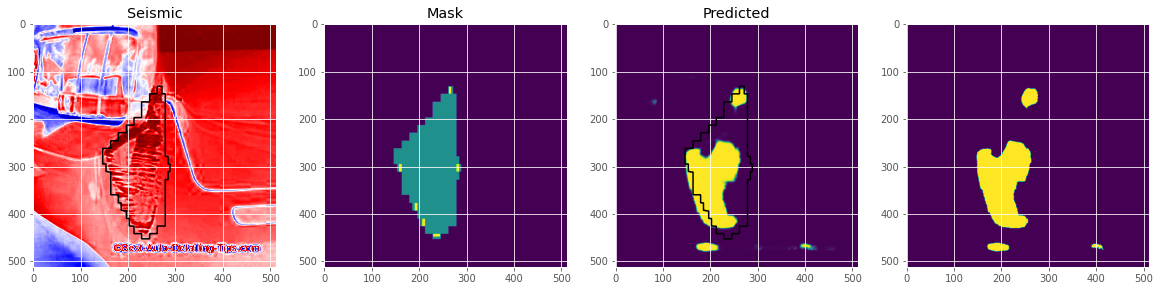

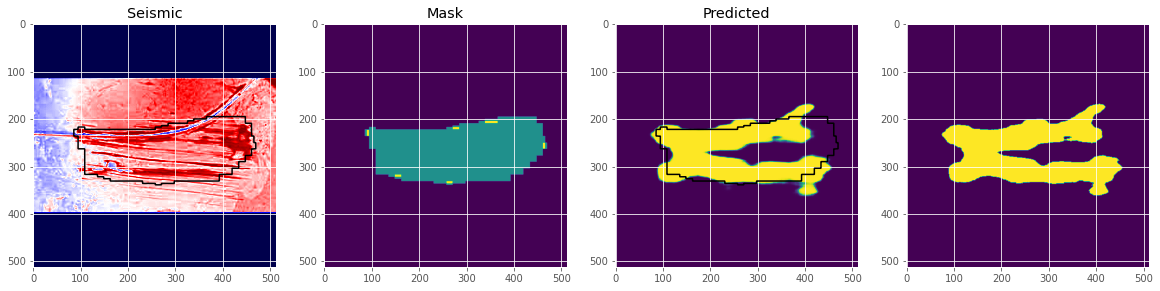

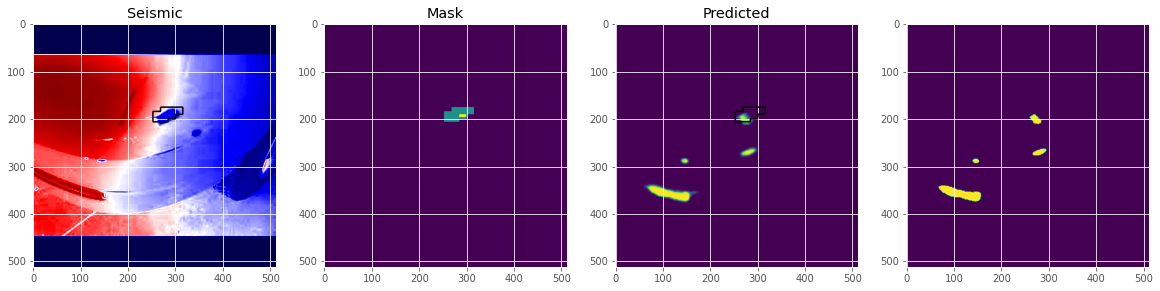

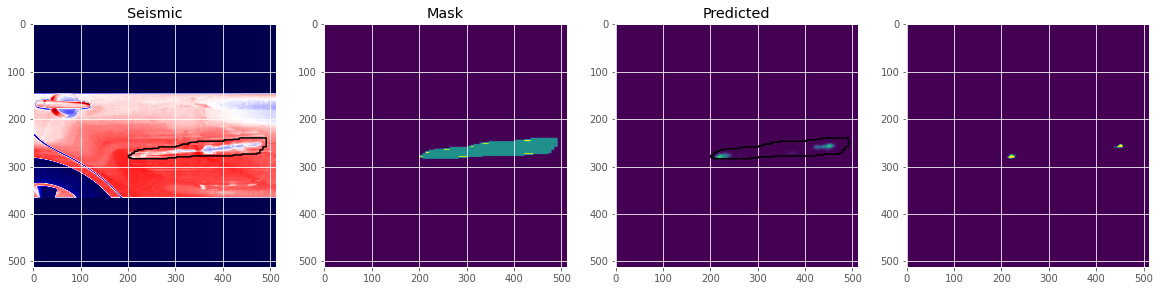

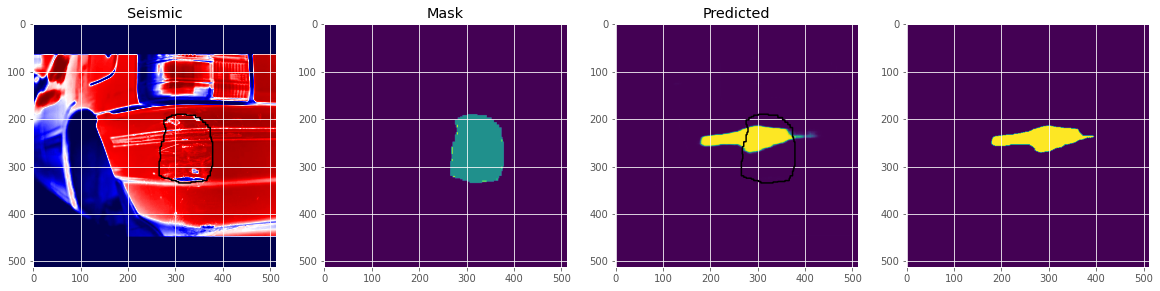

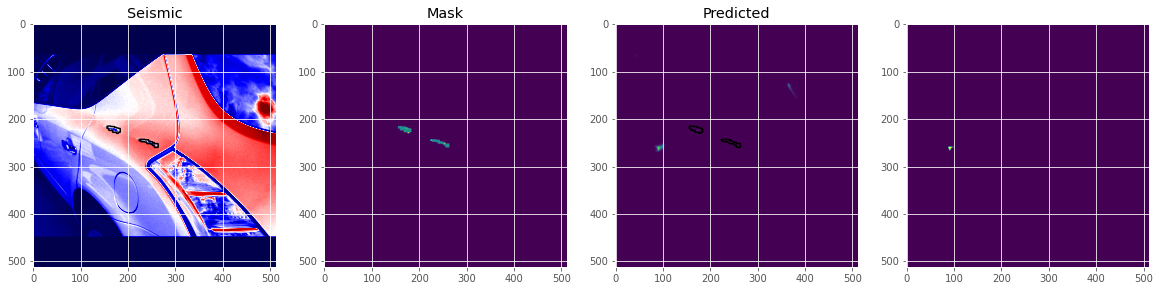

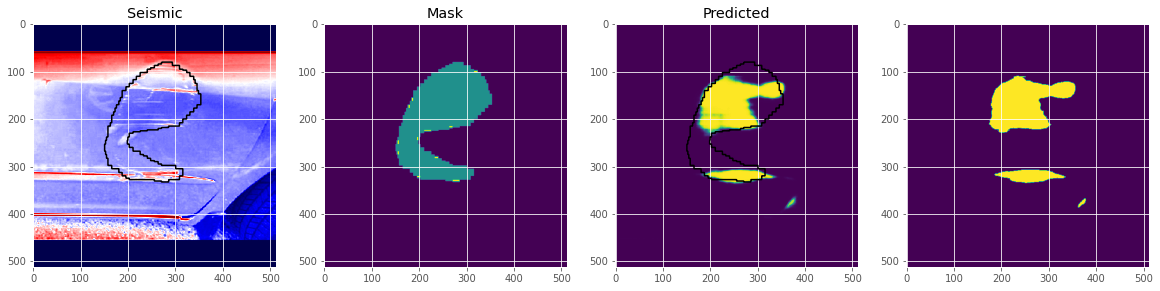

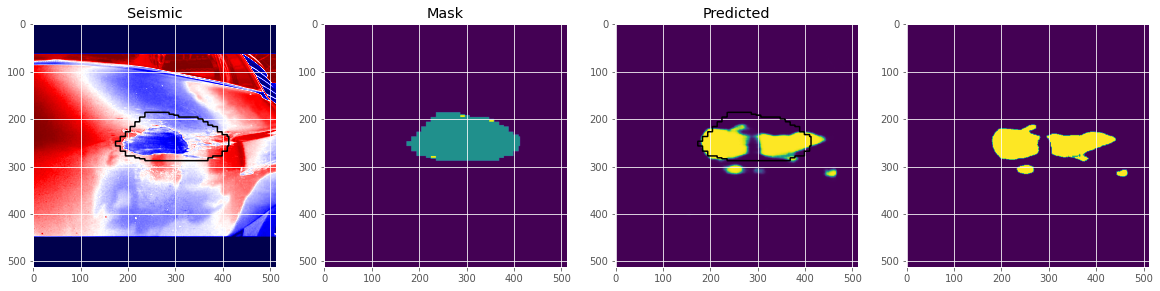

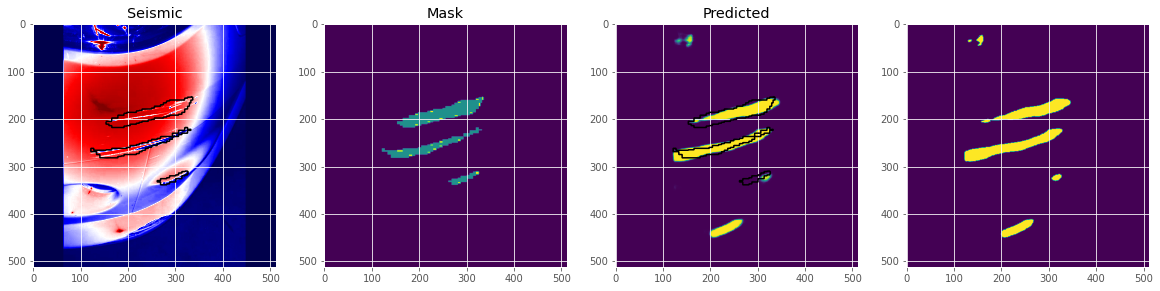

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
#calculating area of damage

In [109]:
pred_labelled_data_dir = '/content/drive/MyDrive/CarDamage/Predictions for labelled data'

In [110]:
img_list=[]
for fn in glob.glob("/content/drive/MyDrive/CarDamage/Predictions for labelled data/*"):
        img_list.append(cv2.imread(fn, 0))

In [111]:
l3=[]
l4=[]
l5=[]
df=pd.DataFrame()
for i,j in zip(os.listdir(pred_labelled_data_dir),img_list):
   l3.append(i)
   l4.append(cv2.countNonZero(j))
   height, width = j.shape
   n_total = height * width
   l5.append(n_total)
df['Filename']=l3 
df['Count of damaged pixels']=l4
df['Total image size']=l5
df['Percentage of damaged pixels']=df['Count of damaged pixels']/df['Total image size']

In [112]:
df.head()

,Filename,Count of damaged pixels,Total image size,Percentage of damaged pixels
0,image2.jpg,17403,120320,0.144639
1,image1.jpeg,20286,141312,0.143555
2,image3.jpg,39647,174080,0.227752
3,image7.jpg,16231,196608,0.082555
4,image4.jpg,9157,196608,0.046575


In [151]:
df.shape

(48, 4)

In [102]:
labelled_data=pd.read_csv("/content/drive/MyDrive/CarDamage/Sev_cost_labelled.csv")

In [103]:
labelled_data.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,image1.jpeg,4794,{},1,0,"{""name"":""polygon"",""all_points_x"":[80,104,178,2...","{""Impact Area"":""Front"",""Severity"":""Minor"",""Rep..."
1,image2.jpg,70052,{},1,0,"{""name"":""polygon"",""all_points_x"":[136,453,649,...","{""Severity"":""Minor"",""Impact Area"":""Side"",""Repa..."
2,image3.jpg,79882,{},1,0,"{""name"":""polygon"",""all_points_x"":[88,59,92,135...","{""Severity"":""Minor"",""Impact Area"":""Side"",""Repa..."
3,image4.jpg,26872,{},1,0,"{""name"":""polygon"",""all_points_x"":[68,124,160,1...","{""Severity"":""Minor"",""Impact Area"":""Side"",""Repa..."
4,image5.jpeg,8689,{},1,0,"{""name"":""polygon"",""all_points_x"":[76,112,137,1...","{""Severity"":""Minor"",""Impact Area"":""Front"",""Rep..."


In [139]:
import json
def string_to_dict(dict_string):
    # Convert to proper json format
    dict_string = dict_string.replace("'", '"').replace('u"', '"')
    return json.loads(dict_string)

In [165]:
bbox = (labelled_data["region_attributes"])

In [166]:
bbox = bbox.apply(string_to_dict)

In [167]:
bbox_list = list(bbox)

In [168]:
bbox_df = pd.DataFrame(bbox_list)

In [169]:
bbox_df.head(5)

,Impact Area,Severity,Repair Cost
0,Front,Minor,300
1,Side,Minor,500
2,Side,Minor,400
3,Side,Minor,250
4,Front,Minor,150


In [170]:
bbox_df.shape

(48, 3)

In [171]:
filenames = labelled_data['filename']

In [172]:
bbox_df['Filename']=filenames

In [191]:
final_df=df.merge(bbox_df,on='Filename',how='inner')

In [174]:
final_df.shape

(46, 7)

In [175]:
final_df.head()

,Filename,Count of damaged pixels,Total image size,Percentage of damaged pixels,Impact Area,Severity,Repair Cost
0,image2.jpg,17403,120320,0.144639,Side,Minor,500
1,image1.jpeg,20286,141312,0.143555,Front,Minor,300
2,image3.jpg,39647,174080,0.227752,Side,Minor,400
3,image7.jpg,16231,196608,0.082555,Side,Minor,220
4,image4.jpg,9157,196608,0.046575,Side,Minor,250


In [192]:
final_df['Repair Cost']=final_df['Repair Cost'].astype(int)

In [194]:
final_df.drop('Filename',axis=1,inplace=True)

KeyError: ignored

In [195]:
cont=final_df[final_df.describe().columns]

In [196]:
cat=final_df.drop(final_df.describe().columns,axis=1)
from sklearn import preprocessing
dummy= pd.get_dummies(cat)
y=cont['Repair Cost']
cont.drop('Repair Cost',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [198]:
fin_df=pd.concat([dummy , cont], axis=1)

In [202]:
fin_df.head()

,Impact Area_All around,Impact Area_Front,Impact Area_Moderate,Impact Area_Rear,Impact Area_Side,Severity_High,Severity_Minor,Severity_Moderate,Count of damaged pixels,Total image size,Percentage of damaged pixels
0,0,0,0,0,1,0,1,0,17403,120320,0.144639
1,0,1,0,0,0,0,1,0,20286,141312,0.143555
2,0,0,0,0,1,0,1,0,39647,174080,0.227752
3,0,0,0,0,1,0,1,0,16231,196608,0.082555
4,0,0,0,0,1,0,1,0,9157,196608,0.046575


In [203]:
fin_df.drop(['Count of damaged pixels',	'Total image size'],axis=1,inplace=True)

In [204]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(fin_df, y, test_size=0.2, random_state=0)
from sklearn import linear_model
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(x_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(x_test)
from sklearn.metrics import mean_squared_error, r2_score
r2_score(y_test,y_pred)

-4.318561555635369

In [205]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, y_pred)

0.6456507587922459

In [206]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor()
reg.fit(x_train, y_train)

y_pred=reg.predict(x_test)
reg.score(x_test, y_test)

-8.160441868279701